# IA048 – Aprendizado de Máquina

## Exercícios de Fixação de Conceitos (EFC) 1 – 2s2020

### Parte 2 – Atividade computacional

### Exercício 1




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn import preprocessing

##### Vamos analisar os dados:

In [2]:
#ler o arquivo csv
data = pd.read_csv('monthly-sunspots.csv',sep = ',')

In [3]:
#visualizar os dados fornecidos
data

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3247,3247,2019-08-31,0.5
3248,3248,2019-09-30,1.1
3249,3249,2019-10-31,0.4
3250,3250,2019-11-30,0.5


Text(0, 0.5, 'Número total de manchas solares')

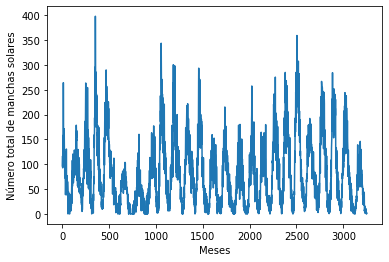

In [47]:
#plotar os dados fornecidos
plt.plot(data['Unnamed: 0'],data['Monthly Mean Total Sunspot Number'])
plt.xlabel('Meses')
plt.ylabel('Número total de manchas solares')

In [48]:
#agora vou converter DataFrame para numpy para começar a fazer as operações

meses = pd.DataFrame.to_numpy(data['Unnamed: 0'])
manchas_solares = pd.DataFrame.to_numpy(data['Monthly Mean Total Sunspot Number'])

##### Separar os dados para usar no treino e teste:

In [49]:
#vamos separar os dados de teste e treino.
#dados de teste são de 2019 à 2010, ou seja, os últimos 10anos*12meses = 120 dados

meses_treino = meses[:-120]
meses_teste = meses[-120:]
manchas_solares_treino = manchas_solares[:-120]
manchas_solares_teste = manchas_solares[-120:]

#para verificar, vamos printar o shape dos meses

print(meses_treino.shape)
print(meses_teste.shape)

(3132,)
(120,)


Vamos criar uma função que nos auxilie à tratar os dados e gerar o dataset correto conforme mude o valor de K passos dados como input no modelo:

In [50]:
def preparar_dataset(dados, K_passos):
    ''' Essa função transforma o dataset inicial no formato correto
    para nossa predição, colocando K_passos no dados_x e a nossa 
    predição do próximo passo no dados_y'''
    
    K_1 = K_passos + 1
    dados_XY = np.zeros(shape=((len(dados)- K_1 + 1),K_1))
    v = 0
    for i in range(len(dados) - K_1 + 1):
        for j in range(K_1):
            dados_XY[i][j] = dados[v]
            v = v + 1
        v = v - K_1 + 1
    #adicionando colunas de 1 e separando em x e y
    dados_x = np.ones(shape=((len(dados)-K_1+1),K_1))
    dados_x[:,:-1] = dados_XY[:,0:K_passos]
    dados_y = dados_XY[:,K_passos]
    return dados_x, dados_y

In [51]:
dados_x, dados_y = preparar_dataset(manchas_solares_treino,10)
#vamos conferir se a função separa corretamente os dados
print(dados_x[-1,:])
print(dados_y[-1])
print(manchas_solares_treino[-10:])

[1.2 0.6 1.2 2.9 6.3 5.5 0.  7.1 7.7 6.9 1. ]
16.3
[ 0.6  1.2  2.9  6.3  5.5  0.   7.1  7.7  6.9 16.3]


### Sem k-fold CV 

Vamos usar a função LinearRegression do sklearn pra fazer as regressões para cada valor de K exigido:

In [52]:
reg = []
for K_steps in range(1,25):
    train_x, train_y = preparar_dataset(manchas_solares_treino, K_steps)
    reg.append(LinearRegression(fit_intercept = True).fit(train_x,train_y))
# reg[0] -> K = 1, reg[1] -> K = 2, ..., reg[23] -> K = 24

Com as regressões e os valores dos coeficientes armazenados em reg, podemos avaliar a qualidade do modelo com os dados de teste:

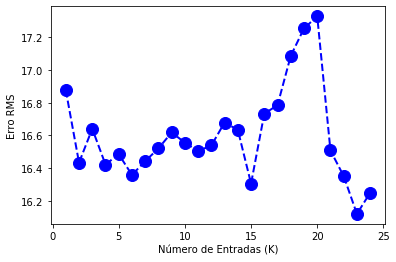

In [53]:
RMSE = []
for K_steps in range(1,25):
    test_x, test_y = preparar_dataset(manchas_solares_teste,K_steps)
    y_pred = reg[K_steps-1].predict(test_x)
    RMSE.append(sqrt(mean_squared_error(y_pred,test_y)))
K_values = np.arange(1,25)
plt.plot(K_values, RMSE, 'bo--', linewidth=2, markersize=12)
plt.xlabel('Número de Entradas (K)')
plt.ylabel('Erro RMS')
plt.show()

Notamos que o melhor coeficiente é dado pelo K=24. Agora vamos usá-lo para prever todo os pontos dos dados de teste com o passar do tempo

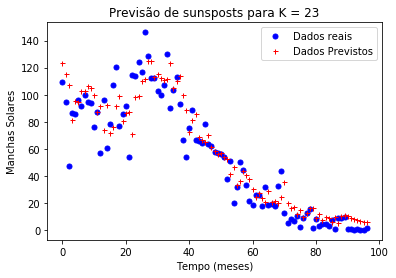

In [54]:
test_x, test_y = preparar_dataset(manchas_solares_teste,23)
y_pred = reg[22].predict(test_x)
plt.plot(test_y, 'bo', markersize=5,label="Dados reais")
plt.plot(y_pred,'r+',markersize=5,label="Dados Previstos")
plt.title("Previsão de sunsposts para K = 23")
plt.xlabel('Tempo (meses)')
plt.ylabel('Manchas Solares')
plt.legend()
plt.show()

### Com k-fold CV 

Mais uma vez, usaremos uma função do sklearn (Kfold) para fazer a operação de k-folder CV:

In [55]:
def apply_k_fold(train_x, train_y ,n_splits):
    kf = KFold(n_splits)
    RMSE = []
    for train_index, validation_index in kf.split(train_x):
        #print("TRAIN:", train_index, "TEST:", validation_index)
        x_train_CV, x_val_CV = train_x[train_index], train_x[validation_index]
        y_train_CV, y_val_CV = train_y[train_index], train_y[validation_index]
        reg = LinearRegression(fit_intercept = True).fit(x_train_CV,y_train_CV)
        y_pred_CV = reg.predict(x_val_CV)
        RMSE.append(sqrt(mean_squared_error(y_pred_CV,y_val_CV)))
    RMSE = np.asarray(RMSE)
    return RMSE.mean()

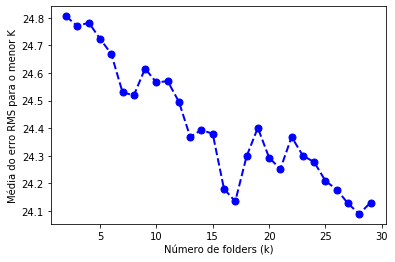

In [56]:
# variar o número de folders do k-fold de 2 a 30 e, para cada um, variar o
# K_steps e pegar o que gera menor erro.
min_RMSE_splits=[]
for splits in range(2,30):
    RMSE_global = []
    for K_steps in range(1,25):
        train_x, train_y = preparar_dataset(manchas_solares_treino, K_steps)
        RMSE_global.append(apply_k_fold(train_x,train_y, splits))
    min_RMSE_splits.append(min(RMSE_global))
SPLITS = np.arange(2,30)
plt.plot(SPLITS,min_RMSE_splits,'bo--',linewidth=2,markersize=7)
plt.xlabel('Número de folders (k)')
plt.ylabel('Média do erro RMS para o menor K')
plt.show()

Notamos que, quanto maior o número de pastas, menor é o erro da nossa predição. Isso é intuitivo pois quanto maior o número de pastas, maior será o conjunto de dados dado ao modelo para treinar - e, ainda, menor é o número de dados de validação. Tendo mais dados de treino e menos dados de validação, o erro diminui. Entretanto, estamos suscetíveis à overfitting.

Como o padrão de escolha é k=10, vamos escolhê-lo para prosseguir.

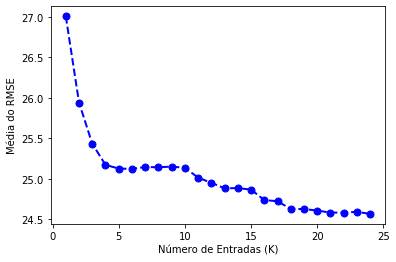

In [57]:
# Agora fixando-se o valor de folders como k = 10 para o k-fold CV e 
# plotando o valor médio do erro RMS em função do número K de dados anteriores
RMSE_global = []
for K_steps in range(1,25):
    train_x, train_y = preparar_dataset(manchas_solares_treino, K_steps)
    RMSE_global.append(apply_k_fold(train_x,train_y, 10))
        
K_values = np.arange(1,25)
plt.plot(K_values, RMSE_global, 'bo--', linewidth=2, markersize=7)
plt.xlabel('Número de Entradas (K)')
plt.ylabel('Média do RMSE')
plt.show()

In [58]:
K_RMS_min = np.argmin(RMSE_global) + 1
print("O valor de K sunspots anteriores que minimiza o erro RMS para a previsão do próximo sunspot (K+1) é de K =",K_RMS_min)

O valor de K sunspots anteriores que minimiza o erro RMS para a previsão do próximo sunspot (K+1) é de K = 24


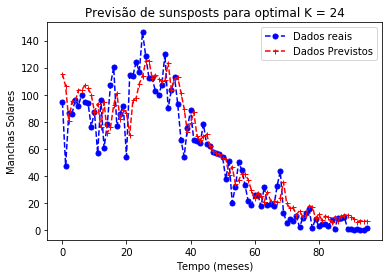

O Valor da média do RMSE para K = 24 é de 16.248971642029392


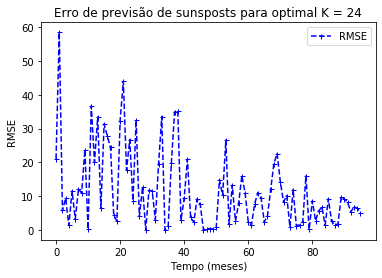

In [59]:
# Como já encontramos o K optimal, basta retreinar o modelo com TODOS os dados (treino + validação)
# e prever os dados de teste
train_x, train_y = preparar_dataset(manchas_solares_treino, 24)
test_x, test_y = preparar_dataset(manchas_solares_teste,24)
reg = LinearRegression(fit_intercept = True).fit(train_x, train_y)
y_pred = reg.predict(test_x)
plt.figure()
plt.plot(test_y, 'bo--', markersize=5,label="Dados reais")
plt.plot(y_pred,'r+--',markersize=5,label="Dados Previstos")
plt.title("Previsão de sunsposts para optimal K = 24")
plt.xlabel('Tempo (meses)')
plt.ylabel('Manchas Solares')
plt.legend()
plt.show()
plt.figure()
print("O Valor da média do RMSE para K = 24 é de", sqrt(mean_squared_error(y_pred,test_y)))
plt.plot(np.sqrt(((y_pred-test_y)*(y_pred-test_y))),'b+--',markersize=5,label="RMSE")
plt.title("Erro de previsão de sunsposts para optimal K = 24")
plt.xlabel('Tempo (meses)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Notamos claramente que há uma diminuição do erro com o passar do tempo. Isso se deve, muito provavelmente, ao comportamento das manchas solares nos últimos meses do conjunto de teste. Notamos claramente que ela se comportamenta de maneira mais estável no final se comparado com os primeiros meses - de modo que a previsão no final seja mais fácil para nosso modelo.

### Exercício 2

Anteriormente, o modelo de predição utilizado era puramente linear, da forma $y_{pred} = w_T x(n) + w_0 $, com $x(n)$ de tamanho (K,N).

Agora, cada variável que anteriormente era dada por $x_k$ será substituída por $x'_k$ da forma:
$$x'k(n) = tanh(w_{k}^{T} x(n))$$ 

sendo w_k um vetor de pesos aleatórios gerados uniformemente.

$w^T$ tem dimensão $(TxK)$ e $x(n)$ tem dimensão de $(K,N)$ de modo que $x'k(n)$ terá dimensão de $(T,N)$, AINDA sendo uma matriz quadrada de entrada, onde T é visto como o número de atributos visto para cada N.

Primeiro, vamos gerar o vetor wk^t:

In [60]:
T = 5
K = 8

Wk = np.random.uniform(low=0.0, high=1.0, size=(T,K))
print(Wk)
print(Wk.shape)

[[0.96351501 0.89735412 0.04832806 0.3395273  0.18106151 0.78129156
  0.7949304  0.82664453]
 [0.27105679 0.23083839 0.19624998 0.41214672 0.12385378 0.00363029
  0.85764389 0.48013394]
 [0.34282668 0.97321306 0.48960305 0.78827437 0.89959921 0.37254142
  0.30961987 0.89682087]
 [0.98612125 0.82079713 0.85749363 0.13392451 0.25465059 0.00181433
  0.83646484 0.21997101]
 [0.03053635 0.70933525 0.82507809 0.33651693 0.16299309 0.33134651
  0.06002237 0.57735944]]
(5, 8)


Note que, para realizar a multiplicação matricial, precisamos preparar o dataset de uma maneira próxima à anterior, salvo que, não adicionaremos uma coluna de 1's no vetor de x neste caso, pois a regressão linear será realizada em função dos elementos x'(n), então o faremos posteriormente

In [61]:
def preparar_dataset_sem_linha(train_np, K_steps):
    ''' This function transforms the initial dataset in a "forecasting type"
        dataset by separating K_steps with the objective to predict the next
        one (K_step + 1)'''
    K_1 = K_steps + 1
    train_XY = np.zeros(shape=((len(train_np)- K_1 + 1),K_1))
    v = 0
    for i in range(len(train_np) - K_1 + 1):
        for j in range(K_1):
            train_XY[i][j] = train_np[v]
            v = v + 1
        v = v - K_1 + 1
    # inserindo termo da última linha pra não sair dos limites
    #adicionando colunas de 1 e separando em x e y
    train_x = train_XY[:,0:K_steps]
    train_y = train_XY[:,K_steps]
    return train_x, train_y

In [62]:
dados_x, dados_y = preparar_dataset_sem_linha(manchas_solares_treino,8)
#vamos conferir se a função separa corretamente os dados
print(Wk.shape)
print(dados_x.T.shape)
print((np.matmul(Wk,(dados_x.T))).shape) #tamanho TxN como previsto

(5, 8)
(8, 3124)
(5, 3124)


Vamos agora aplicar a tangente hiperbolica e ver o resultado

In [63]:
dados_x_linha = np.tanh(np.matmul(Wk,(dados_x.T)))
print(dados_x_linha.shape)
print("dados antes da tanh\n", np.matmul(Wk,(dados_x.T)))
print("##############################################################")
print("dados depois da tanh\n", dados_x_linha)

(5, 3124)
dados antes da tanh
 [[575.2693796  598.86987548 569.31796422 ...  14.04422064  16.93911438
   23.30239333]
 [318.0551767  305.14387794 327.09642249 ...   6.10369306  14.07278816
   14.44043855]
 [592.29561987 638.21101932 644.71607241 ...  17.95272021  21.81114651
   21.87089926]
 [486.26955067 453.18170683 505.31989416 ...   6.26926891  13.94034063
   17.67391282]
 [346.95322303 364.92588799 375.73797016 ...   9.37675186  11.15059574
   15.94106352]]
##############################################################
dados depois da tanh
 [[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 0.99999001 1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 0.99999283 1.         1.        ]
 [1.         1.         1.         ... 0.99999999 1.         1.        ]]


Claramente é necessário normalizar os dados para que possamos usar a função tanh para nossa transformação não-linear.

O range de normalização é uma escolha nossa. Sabemos que à partir de 2 a tangente hiperbólica transforma quase todo número em 1.

Após alguns testes, eu vi que o melhor range é entre -0.5 e 0.5. Quando tentei com 2 ou 1 como range, o gráfico ficou extremamente concentrado nos valores mais baixos...

[[-0.25715721 -0.23807132 -0.20693119 ... -0.15042692 -0.10321447
  -0.22250126]
 [-0.23807132 -0.20693119 -0.26695128 ... -0.10321447 -0.22250126
  -0.18232044]
 [-0.20693119 -0.26695128 -0.14414867 ... -0.22250126 -0.18232044
  -0.18407835]
 ...
 [-0.49698644 -0.49849322 -0.49698644 ... -0.48618785 -0.5
  -0.48216976]
 [-0.49849322 -0.49698644 -0.49271723 ... -0.5        -0.48216976
  -0.48066298]
 [-0.49698644 -0.49271723 -0.4841788  ... -0.48216976 -0.48066298
  -0.48267202]]


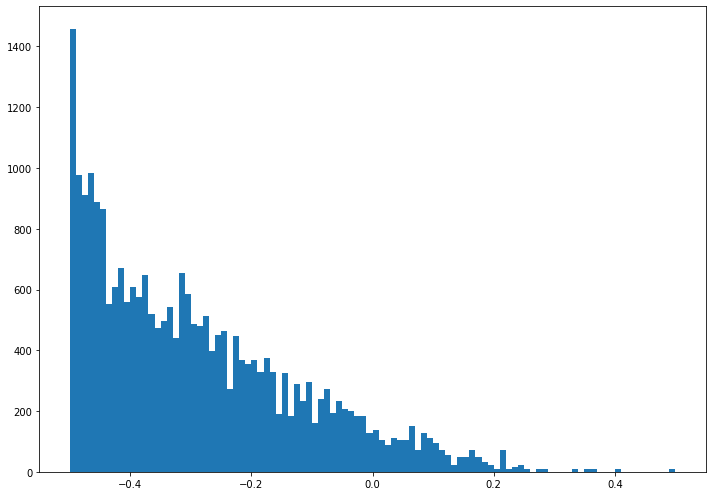

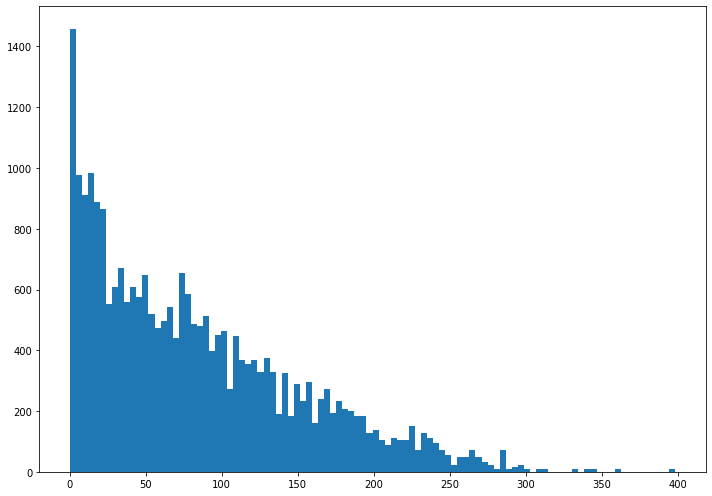

array([[ True,  True, False, ...,  True,  True, False],
       [ True, False,  True, ...,  True, False,  True],
       [False,  True,  True, ..., False,  True, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False,  True]])

In [64]:
#o scaler:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.5,0.5))

#normalizando. vou normalizar direto os dados
#(e não Wk*X(n) pois Wk já está normalizado entre 0 e 1)
dados_x_norm = min_max_scaler.fit_transform(dados_x)

#desnormalizando:
dados_x_desnorm = min_max_scaler.inverse_transform(dados_x_norm)

#verificando a normalização
print(dados_x_norm)

fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True) 
axs.hist(dados_x_norm.reshape(-1), bins = 100) 
plt.show()

fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True) 
axs.hist(dados_x.reshape(-1), bins = 100) 
plt.show()

#verificar se a transformação inversa deu certo. iremos usá-la mais pra frente
dados_x_desnorm == (dados_x)

Normalização deu certo, porém temos que tomar cuidado com o excesso de pontos na extremidade! Veremos se a transformação feita pela tanh hiperbólica não concentra ainda mais os pontos nessa região (com o range entre -0.5 e 0.5 ficou bem ok)

(5, 3124)


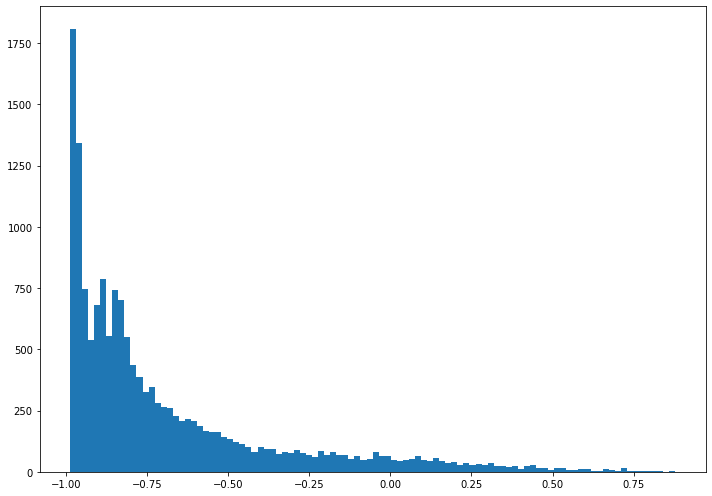

In [65]:
dados_x_linha = np.tanh(np.matmul(Wk,(dados_x_norm.T)))
print(dados_x_linha.shape)

fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True) 
axs.hist(dados_x_linha.reshape(-1), bins = 100) 
plt.show() 

    Agora que verificamos as operações, vamos fazê-las com todos os dados e k-fold. Além disso, precisamos lembrar q temos que inserir uma coluna de 1's nos dados de x':

In [66]:
def insert_ligne_ones(train_x):
    train_x_new = np.ones(shape=(T+1,(len(train_x.T))))
    train_x_new[:-1,:] = train_x
    return train_x_new

train_x_new = insert_ligne_ones(dados_x_linha)
print(train_x_new,"\n",train_x_new.shape)

[[-0.74942924 -0.72227445 -0.75590777 ... -0.98304984 -0.98280372
  -0.9822502 ]
 [-0.45345786 -0.47883285 -0.43523685 ... -0.85445993 -0.84896529
  -0.84870725]
 [-0.78134592 -0.7322259  -0.72455741 ... -0.98637728 -0.98611256
  -0.98610842]
 [-0.68285795 -0.72473302 -0.65648339 ... -0.96673909 -0.96545515
  -0.96481274]
 [-0.56849075 -0.53716008 -0.51756123 ... -0.90388371 -0.90306524
  -0.90082171]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]] 
 (6, 3124)


In [79]:
def apply_k_fold_renorm(train_x, train_y ,n_splits):
    kf = KFold(n_splits)
    RMSE = []
    for train_index, validation_index in kf.split(train_x):
        #print("TRAIN:", train_index, "TEST:", validation_index)
        x_train_CV, x_val_CV = train_x[train_index], train_x[validation_index]
        y_train_CV, y_val_CV = train_y[train_index], train_y[validation_index]
        reg = LinearRegression(fit_intercept = True).fit(x_train_CV,y_train_CV)
        y_pred_CV = reg.predict(x_val_CV)
        RMSE.append(sqrt(mean_squared_error(min_max_scaler.inverse_transform(y_pred_CV.reshape(-1,1)),min_max_scaler.inverse_transform(y_val_CV.reshape(-1,1)))))
    RMSE = np.asarray(RMSE)
    return RMSE.mean()

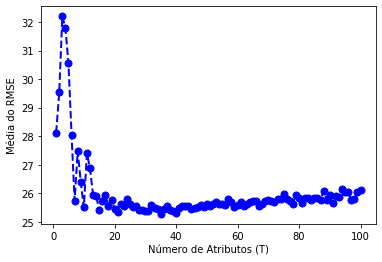

In [80]:
# k = 10 para o k-fold CV e 
# plotando o valor médio do erro RMS em função do número T de atributos

K = 8 
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.5,0.5))


#notamos que será melhor normalizar TODOS os dados juntos
#deste modo não teremos problemas de proporção com os dados de teste
ms_norm = min_max_scaler.fit_transform(manchas_solares.reshape(-1,1))

#agora separo em treino e teste
manchas_solares_treino = ms_norm[:-120]
manchas_solares_teste = ms_norm[-120:]

#vamos treinar. p isso, separar o X do Y nos dados de treino:
dados_x, dados_y = preparar_dataset_sem_linha(manchas_solares_treino.reshape(-1),K)

RMSE_global = []
for T in range(1,101):
    Wk = np.random.uniform(low=0.0, high=1.0, size=(T,K))
    dados_x_linha = insert_ligne_ones(np.tanh(np.matmul(Wk,(dados_x.T))))
    RMSE_global.append(apply_k_fold_renorm(dados_x_linha.T,dados_y, 10))
        
T_values = np.arange(1,101)
plt.plot(T_values, RMSE_global, 'bo--', linewidth=2, markersize=7)
plt.xlabel('Número de Atributos (T)')
plt.ylabel('Média do RMSE')
plt.show()

Agora vamos colocar o ridge regression. Depois teremos que encontrar o valor de Alpha optimal:

In [83]:
def apply_k_fold_ridge_regression(train_x, train_y ,n_splits, Alpha):
    kf = KFold(n_splits)
    RMSE = []
    for train_index, validation_index in kf.split(train_x):
        #print("TRAIN:", train_index, "TEST:", validation_index)
        x_train_CV, x_val_CV = train_x[train_index], train_x[validation_index]
        y_train_CV, y_val_CV = train_y[train_index], train_y[validation_index]
        reg = Ridge(alpha = Alpha, fit_intercept = True).fit(x_train_CV,y_train_CV)
        y_pred_CV = reg.predict(x_val_CV)
        RMSE.append(sqrt(mean_squared_error(min_max_scaler.inverse_transform(y_pred_CV.reshape(-1,1)),min_max_scaler.inverse_transform(y_val_CV.reshape(-1,1)))))
    RMSE = np.asarray(RMSE)
    return RMSE.mean()

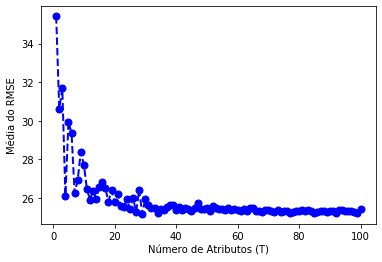

In [91]:
# k = 10 para o k-fold CV e 
# plotando o valor médio do erro RMS em função do número T de atributos
# Neste caso fixamos alfa = 0.1
K = 8
RMSE_global = []

for T in range(1,101):
    W_T = np.random.uniform(low=0.0, high=1.0, size=(T,K))
    dados_x_linha = insert_ligne_ones(np.tanh(np.matmul(W_T,(dados_x.T))))
    RMSE_global.append(apply_k_fold_ridge_regression(dados_x_linha.T,dados_y, 10,0.1))
        
T_values = np.arange(1,101)
plt.plot(T_values, RMSE_global, 'bo--', linewidth=2, markersize=7)
plt.xlabel('Número de Atributos (T)')
plt.ylabel('Média do RMSE')
plt.show()

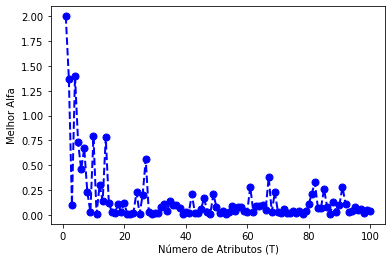

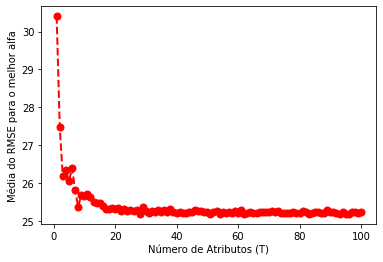

In [95]:
# k = 10 para o k-fold CV e 
# plotando o melhor alfa para cada T (o melhor alfa é o que apresenta o menor RMS)
K = 8
min_RMSE_alfa = []
vector = np.linspace(0.01,2,200)
alfa_optimal = []
for T in range(1,101):
    RMSE_global = []
    for alfa in vector:
        W_T = np.random.uniform(low=0.0, high=1.0, size=(T,K))
        dados_x_linha = insert_ligne_ones(np.tanh(np.matmul(W_T,(dados_x.T))))
        RMSE_global.append(apply_k_fold_ridge_regression(dados_x_linha.T,dados_y, 10, alfa))
    alfa_optimal.append(vector[np.argmin(RMSE_global)])
    min_RMSE_alfa.append(np.min(RMSE_global))
    
T_values = np.arange(1,101)
plt.plot(T_values, alfa_optimal, 'bo--', linewidth=2, markersize=7)
plt.xlabel('Número de Atributos (T)')
plt.ylabel('Melhor Alfa')
plt.show()

plt.plot(T_values, min_RMSE_alfa,'ro--', linewidth=2, markersize=7)
plt.xlabel('Número de Atributos (T)')
plt.ylabel('Média do RMSE para o melhor alfa')
plt.show()

In [96]:
print('A mínima média de RMSE encontrada é de:', np.min(min_RMSE_alfa), 
      'para T=',T_values[np.argmin(min_RMSE_alfa)], 
      'com parâmetro de regularização de alfa =',alfa_optimal[np.argmin(min_RMSE_alfa)])

A mínima média de RMSE encontrada é de: 25.186031386739295 para T= 95 com parâmetro de regularização de alfa = 0.08


(3124, 8) (96, 3124) (112, 8) (96, 112)


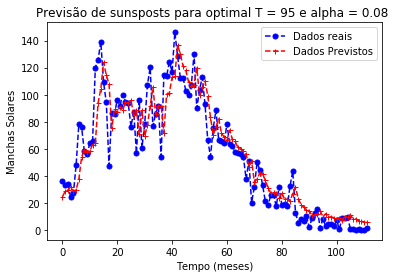

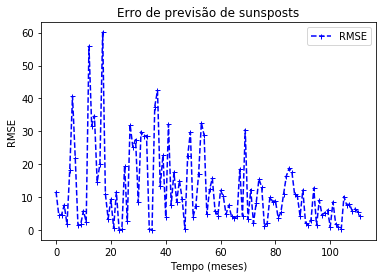

In [100]:
T = 95
K = 8
Alpha = 0.08
W_T = np.random.uniform(low=0.0, high=1.0, size=(T,K))

test_x, test_y = preparar_dataset_sem_linha(manchas_solares_teste.reshape(-1),K)
train_x, train_y = preparar_dataset_sem_linha(manchas_solares_treino.reshape(-1),K)

dados_x_linha_teste = insert_ligne_ones(np.tanh(np.matmul(W_T,(test_x.T))))
dados_x_linha_treino = insert_ligne_ones(np.tanh(np.matmul(W_T,(train_x.T))))

print(train_x.shape,dados_x_linha_treino.shape,test_x.shape,dados_x_linha_teste.shape)
reg = Ridge(alpha = Alpha, fit_intercept = True).fit(dados_x_linha_treino.T,train_y)
y_pred_new = reg.predict(dados_x_linha_teste.T)
y_pred_new = min_max_scaler.inverse_transform(y_pred_new.reshape(-1,1))
test_y = min_max_scaler.inverse_transform(test_y.reshape(-1,1))
print(sqrt(mean_squared_error(y_pred_new,test_y)))
plt.figure()
plt.plot(test_y, 'bo--', markersize=5,label="Dados reais")
plt.plot(y_pred_new,'r+--',markersize=5,label="Dados Previstos")
plt.title("Previsão de sunsposts para optimal T = 95 e alpha = 0.08 ")
plt.xlabel('Tempo (meses)')
plt.ylabel('Manchas Solares')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.sqrt(((y_pred_new-test_y)*(y_pred_new-test_y))),'b+--',markersize=5,label="RMSE")
plt.title("Erro de previsão de sunsposts")
plt.xlabel('Tempo (meses)')
plt.ylabel('RMSE')
plt.legend()
plt.show()